- **Nama:** Aulia Afifah
- **ID Dicoding:** auliaafifah253

# Menyiapkan Library

In [2]:
import os
import random
import shutil
import matplotlib.pyplot as plt
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pathlib

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from kaggle.api.kaggle_api_extended import KaggleApi

In [3]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d 'yusuftaqiyuddin/fruit-12'

mkdir: cannot create directory ‘/root/.kaggle’: File exists
Dataset URL: https://www.kaggle.com/datasets/yusuftaqiyuddin/fruit-12
License(s): unknown
 99% 378M/383M [00:03<00:00, 112MB/s]
100% 383M/383M [00:03<00:00, 110MB/s]


In [4]:
!unzip -q fruit-12.zip -d fruit-12-data

In [5]:
destination_folder = "df"
os.makedirs(destination_folder, exist_ok=True)

fruit_folders = ["Apple", "Mango", "Melon"]

for fruit in fruit_folders:
    src_folder = f"fruit-12-data/{fruit}"
    dst_folder = os.path.join(destination_folder, fruit)
    shutil.move(src_folder, dst_folder)

print(f"Folder buah yang dipilih sudah dipindahkan ke dalam --> {destination_folder}")

Folder buah yang dipilih sudah dipindahkan ke dalam --> df


In [6]:
!rm fruit-12.zip

# Preprocessing data

In [7]:
train_folder = os.path.join(destination_folder, "train")
test_folder = os.path.join(destination_folder, "test")
os.makedirs(train_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

In [8]:
train_size_ratio = 0.8

for fruit in fruit_folders:
    fruit_src_folder = os.path.join(destination_folder, fruit)
    fruit_train_folder = os.path.join(train_folder, fruit)
    fruit_test_folder = os.path.join(test_folder, fruit)

    os.makedirs(fruit_train_folder, exist_ok=True)
    os.makedirs(fruit_test_folder, exist_ok=True)

    images = os.listdir(fruit_src_folder)

    random.shuffle(images)
    train_size = int(train_size_ratio * len(images))

    train_images = images[:train_size]
    test_images = images[train_size:]

    for image in train_images:
        src_path = os.path.join(fruit_src_folder, image)
        dst_path = os.path.join(fruit_train_folder, image)
        shutil.move(src_path, dst_path)

    for image in test_images:
        src_path = os.path.join(fruit_src_folder, image)
        dst_path = os.path.join(fruit_test_folder, image)
        shutil.move(src_path, dst_path)

print(f"Data tersebut telah dibagi ke dalam folder train dan test di --> {destination_folder}")

Data tersebut telah dibagi ke dalam folder train dan test di --> df


In [9]:
fruit_folders = ["Apple", "Mango", "Melon"]

for fruit in fruit_folders:
    fruit_folder = os.path.join(destination_folder, fruit)

    if os.path.exists(fruit_folder):
        shutil.rmtree(fruit_folder)
        print(f"Folder {fruit} telah dihapus yaaa")
    else:
        print(f"Folder {fruit} tidak ditemukan atau sudah dihapus sebelumnyaaa")

Folder Apple telah dihapus yaaa
Folder Mango telah dihapus yaaa
Folder Melon telah dihapus yaaa


In [10]:
TRAINING_DIR = "df/train"
VALIDATION_DIR = "df/test"

train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,
    shear_range=0.2,
    zoom_range=0.2,
    vertical_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=32,
                                                    class_mode='categorical',
                                                    target_size=(150, 150))

Found 4716 images belonging to 3 classes.


In [11]:
validation_datagen = ImageDataGenerator(
    rescale=1.0/255
)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                            batch_size=16,
                                                            class_mode='categorical',
                                                            target_size=(150, 150))

Found 1180 images belonging to 3 classes.


# Membuat model

In [12]:
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs is not None:
            accuracy = logs.get('accuracy')
            if accuracy > 0.95:
                print("\nAkurasi telah mencapai >95%!")
                self.model.stop_training = True

In [13]:
callbacks = MyCallback()

In [14]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])

In [15]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Melatih model

In [16]:
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=[callbacks]
)

Epoch 1/30
148/148 [==============================] - 179s 1s/step - loss: 1.1911 - accuracy: 0.8679 - val_loss: 0.0735 - val_accuracy: 0.9729
Epoch 2/30
148/148 [==============================] - ETA: 0s - loss: 0.0649 - accuracy: 0.9763
Akurasi telah mencapai >95%!
148/148 [==============================] - 183s 1s/step - loss: 0.0649 - accuracy: 0.9763 - val_loss: 0.0219 - val_accuracy: 0.9975


In [17]:
test_loss, test_acc = model.evaluate(validation_generator)
print(f"Test accuracy menunjukkan: {test_acc * 100:.2f}%")

74/74 [==============================] - 9s 119ms/step - loss: 0.0219 - accuracy: 0.9975
Test accuracy menunjukkan: 99.75%


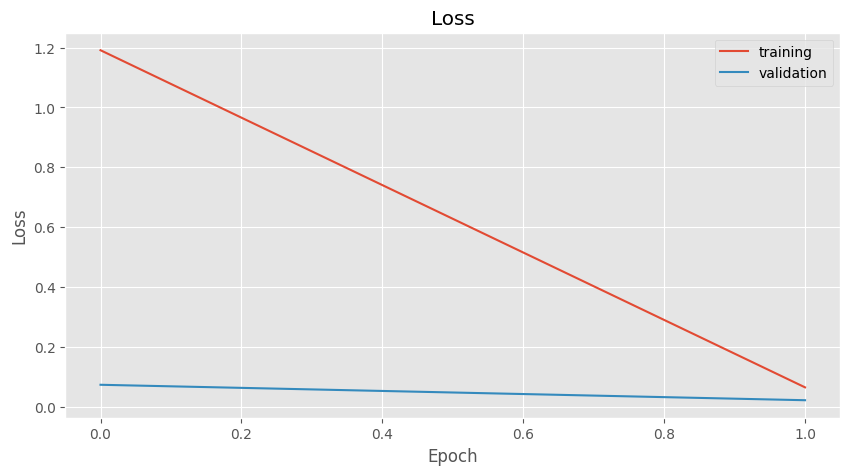

In [18]:
epochs = len(history.history['loss'])

plt.style.use("ggplot")
plt.figure(figsize=(10, 5))
plt.plot(np.arange(0, epochs), history.history["loss"], label="training")
plt.plot(np.arange(0, epochs), history.history["val_loss"], label="validation")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

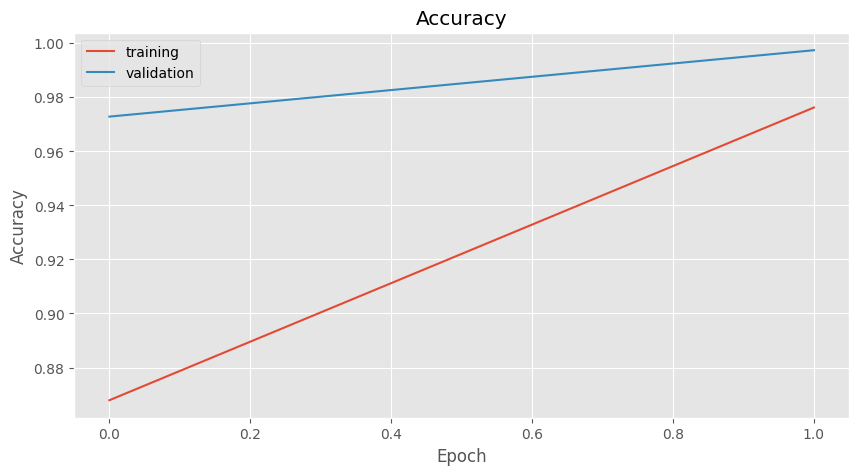

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(np.arange(0, epochs), history.history["accuracy"], label="training")
plt.plot(np.arange(0, epochs), history.history["val_accuracy"], label="validation")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Mengubah model

In [20]:
export_dir = 'saved_model/'
tf.saved_model.save(model, export_dir)

In [21]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

In [22]:
tflite_model_file = pathlib.Path('vegs.tflite')
tflite_model_file.write_bytes(tflite_model)

89727152